In [4]:
!unzip -n Gano.zip

/bin/bash: /home/ubuntu/anaconda3/envs/yuyu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  Gano.zip


## 1. Reading Modules


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from scipy import ndimage, misc
import skimage
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout



2023-06-13 04:43:15.152111: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 04:43:15.240124: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 04:43:15.951329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os

filelist  = []

for dirname, _, filenames in os.walk('./Gano-Cat-Breeds-V1_1/'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            filelist.append (os.path.join(dirname, filename))
        
Filepaths   = []
labels = []

for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    Filepaths.append(image_file)
    labels.append(label)


set(labels), len(Filepaths), len(labels)

({'Abyssinian',
  'American Bobtail',
  'American Shorthair',
  'Bengal',
  'Birman',
  'Bombay',
  'British Shorthair',
  'Egyptian Mau',
  'Maine Coon',
  'Persian',
  'Ragdoll',
  'Russian Blue',
  'Siamese',
  'Sphynx',
  'Tuxedo'},
 5625,
 5625)

### Creating a dataframe with file paths and the labels for them

In [4]:
df = pd.DataFrame( list( zip (Filepaths, labels) ), columns = ['Filepath', 'Labels'] )
df

,Filepath,Labels
0,./Gano-Cat-Breeds-V1_1/American Shorthair/Amer...,American Shorthair
1,./Gano-Cat-Breeds-V1_1/American Shorthair/Amer...,American Shorthair
2,./Gano-Cat-Breeds-V1_1/American Shorthair/Amer...,American Shorthair
3,./Gano-Cat-Breeds-V1_1/American Shorthair/Amer...,American Shorthair
4,./Gano-Cat-Breeds-V1_1/American Shorthair/Amer...,American Shorthair
...,...,...
5620,./Gano-Cat-Breeds-V1_1/Maine Coon/Maine_Coon-4...,Maine Coon
5621,./Gano-Cat-Breeds-V1_1/Maine Coon/Maine_Coon_1...,Maine Coon
5622,./Gano-Cat-Breeds-V1_1/Maine Coon/Maine_Coon_1...,Maine Coon
5623,./Gano-Cat-Breeds-V1_1/Maine Coon/Maine_Coon_2...,Maine Coon


In [5]:
from sklearn.utils import shuffle
df = (df.sample(frac = 1).reset_index()).drop(columns = 'index')
df


,Filepath,Labels
0,./Gano-Cat-Breeds-V1_1/American Shorthair/Amer...,American Shorthair
1,./Gano-Cat-Breeds-V1_1/Bombay/Bombay_87.jpg,Bombay
2,./Gano-Cat-Breeds-V1_1/Birman/Birman_142.jpg,Birman
3,./Gano-Cat-Breeds-V1_1/Sphynx/Sphynx_235.jpg,Sphynx
4,./Gano-Cat-Breeds-V1_1/Sphynx/Sphynx_82.jpg,Sphynx
...,...,...
5620,./Gano-Cat-Breeds-V1_1/Bengal/Bengal_144.jpg,Bengal
5621,./Gano-Cat-Breeds-V1_1/American Shorthair/Amer...,American Shorthair
5622,./Gano-Cat-Breeds-V1_1/Bombay/Bombay-23304370_...,Bombay
5623,./Gano-Cat-Breeds-V1_1/Tuxedo/Tuxedo-42790069_...,Tuxedo


### Displaying first 12 pictures

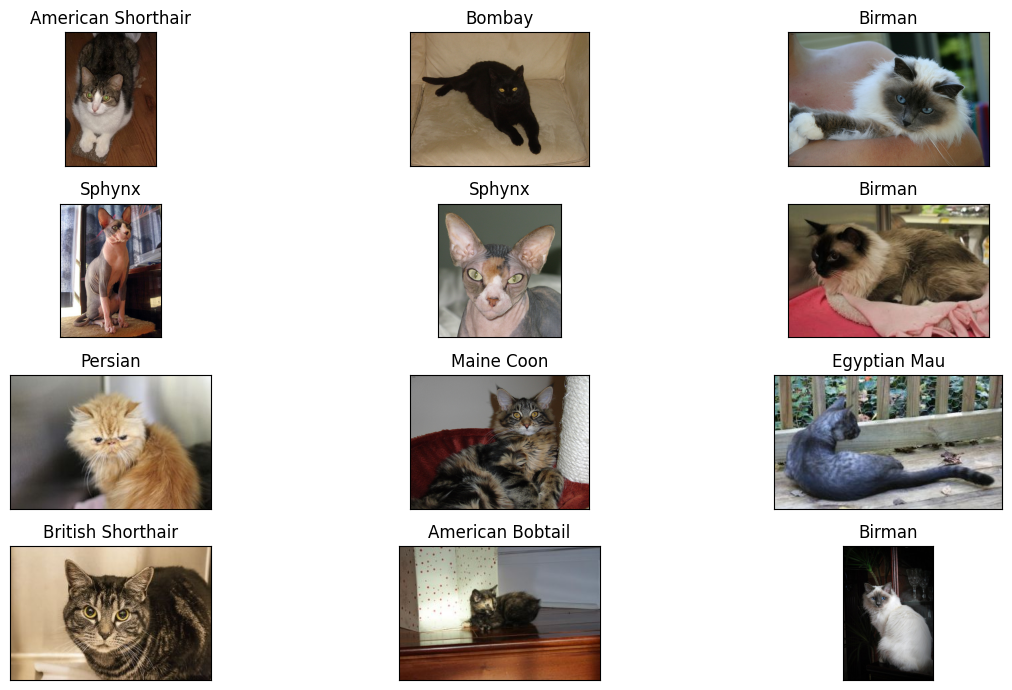

In [6]:
f,a = plt.subplots(nrows=4, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    
plt.tight_layout()
plt.show()

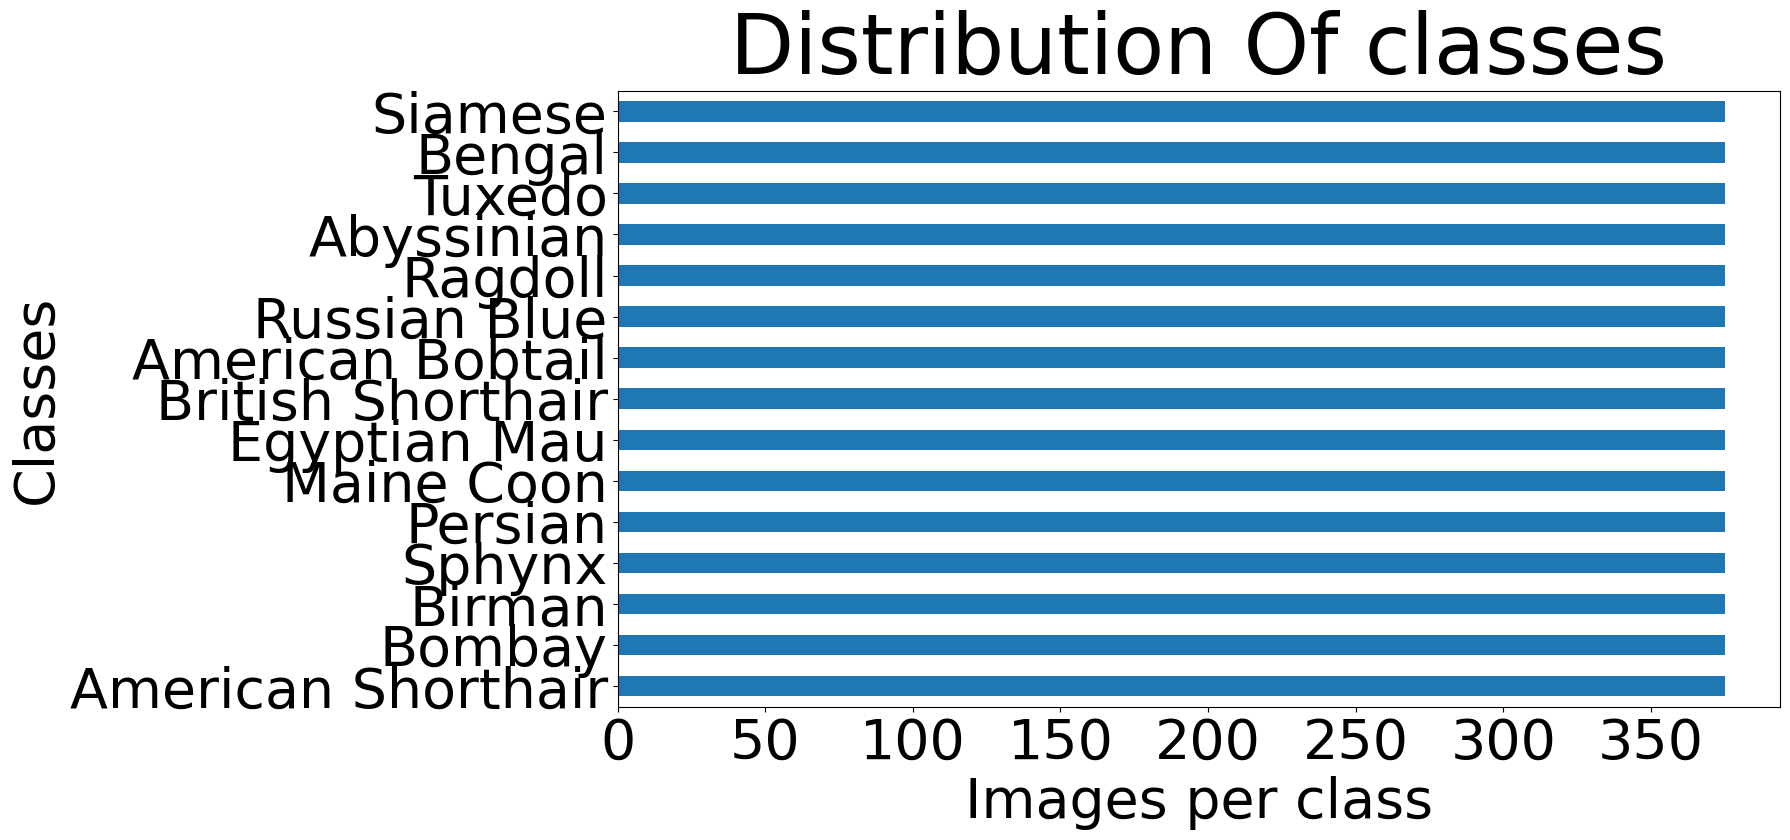

In [7]:
ax=pd.value_counts(df['Labels'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Distribution Of classes",
                                                       figsize=(15,8))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

### Checking for class imbalance

In [8]:
df.Labels.value_counts()

Labels
American Shorthair    375
Bombay                375
Birman                375
Sphynx                375
Persian               375
Maine Coon            375
Egyptian Mau          375
British Shorthair     375
American Bobtail      375
Russian Blue          375
Ragdoll               375
Abyssinian            375
Tuxedo                375
Bengal                375
Siamese               375
Name: count, dtype: int64

### Splitting the data And Creating data generator

In [9]:
train_ratio = .75
validation_ratio = 0.10
test_ratio = 0.25

train, test = train_test_split(df, test_size = test_ratio )
val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio))

In [10]:
img_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
   

x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10)
x_val = img_datagen.flow_from_dataframe(dataframe = val,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10)
x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Filepath', y_col='Labels',  target_size=(299, 299), shuffle=False, batch_size=10, seed=10)

Found 4218 validated image filenames belonging to 15 classes.
Found 402 validated image filenames belonging to 15 classes.
Found 1005 validated image filenames belonging to 15 classes.


In [11]:
x_train

### Modelling

In [12]:

i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(299, 299, 3))

2023-06-13 04:44:05.065964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13599 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [13]:
for layer in i_model.layers:
    layer.trainable = False
    
i_model.summary() 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [14]:
number_lables = len(set(labels))
print(number_lables)
model = Sequential()
model.add(i_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(number_lables, activation = 'softmax'))
model.summary()

15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 22,066,991
Trainable params: 264,207
Non-trainable params: 21,802,784
___________________________________

In [15]:
model.compile(optimizer = SGD(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [16]:
history = model.fit(x_train, validation_data = x_val,steps_per_epoch = 175,validation_steps = 44,
                epochs = 15, verbose = 2)

Epoch 1/15


2023-06-13 04:44:27.763007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-13 04:44:32.964881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


2023-06-13 04:45:55.852616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


175/175 - 98s - loss: 1.7829 - accuracy: 0.4471 - val_loss: 1.2455 - val_accuracy: 0.6318 - 98s/epoch - 562ms/step


### Predicting on test data

In [17]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
predictions

2023-06-13 04:46:24.849113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 22s 642ms/step


array([14,  5,  2, ..., 10,  5,  7])

In [18]:
labels = x_train.class_indices
labels

{'Abyssinian': 0,
 'American Bobtail': 1,
 'American Shorthair': 2,
 'Bengal': 3,
 'Birman': 4,
 'Bombay': 5,
 'British Shorthair': 6,
 'Egyptian Mau': 7,
 'Maine Coon': 8,
 'Persian': 9,
 'Ragdoll': 10,
 'Russian Blue': 11,
 'Siamese': 12,
 'Sphynx': 13,
 'Tuxedo': 14}

In [19]:
test["Labels"].replace(labels, inplace = True)


# Evaluating the test data

## Test Accuracy

In [20]:
test_accuracy = model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

2023-06-13 04:47:54.014753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 19s 587ms/step - loss: 1.2603 - accuracy: 0.6239
Test accuracy is :  62.388062477111816 %


## Confusion Matrix

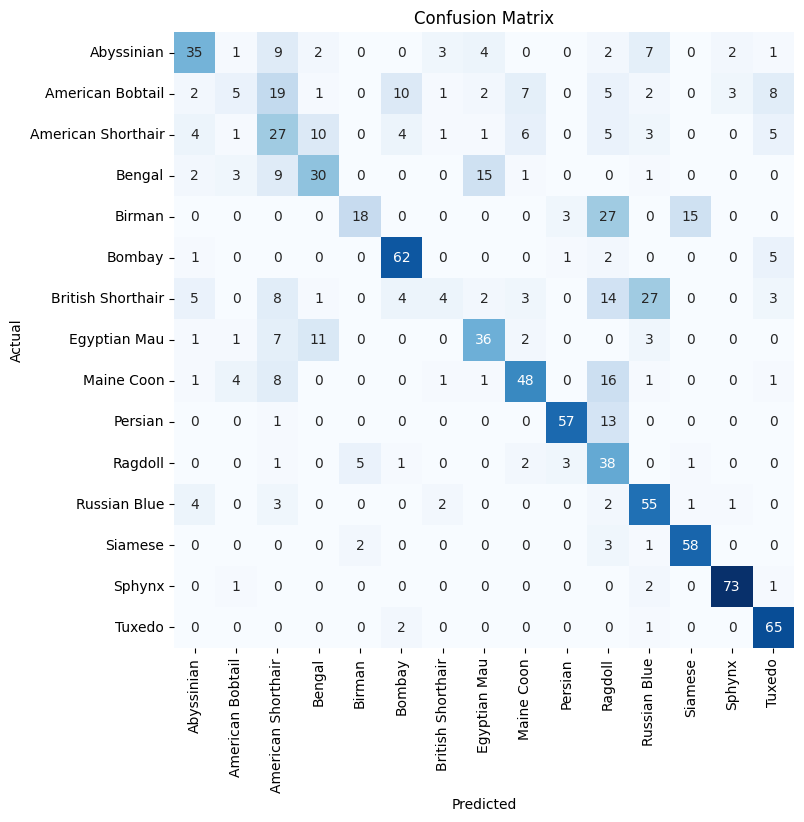

In [21]:
classes = list(labels.keys())
class_count = len(classes)

import seaborn as sns

cm = confusion_matrix(test.Labels , predictions)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## F1 Score

In [22]:
from sklearn.metrics import accuracy_score, f1_score
print('F1 score is',f1_score(test.Labels, predictions, average = 'weighted'))


F1 score is 0.5824789214905243
